In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

sensor_names = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z']
# Last row of training data for train/test split
train_end_index = 3511

In [51]:
labels = np.loadtxt('labels_train_1.csv', dtype='int')
data_slice_0 = np.loadtxt(sensor_names[0] + '_train_1.csv',
                            delimiter=',')
data = np.empty((data_slice_0.shape[0], data_slice_0.shape[1],
                    len(sensor_names)))
data[:, :, 0] = data_slice_0
del data_slice_0
for sensor_index in range(1, len(sensor_names)):
    data[:, :, sensor_index] = np.loadtxt(
        sensor_names[sensor_index] + '_train_1.csv', delimiter=',')
    

acc_data = data[:,:, 0:3]
gyr_data = data[:,:, 3:6]

total_acc = np.linalg.norm(acc_data, axis=-1)
total_gyr = np.linalg.norm(gyr_data, axis=-1)


total_data = np.stack((total_acc, total_gyr), axis=-1)

In [52]:
train_data = total_data[:train_end_index+1, :, :]
train_labels = labels[:train_end_index+1]
test_data = total_data[train_end_index+1:, :, :]
test_labels = labels[train_end_index+1:]

In [77]:
class FirstCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Parameters:
        - num_classes: Number of output classes (for classification tasks).
        """
        super(FirstCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully Connected Layer (adjust input size based on conv/pooling output)
        self.fc1 = nn.Linear(64 * 7, 128)  # Flattened size after convolutions and pooling
        self.fc2 = nn.Linear(128, num_classes)  # Output layer with 4 classes
        
    def forward(self, x):

        x = x.permute(0, 2, 1)
        
        # Pass through conv1 -> ReLU -> Max Pool
        x = self.pool(F.relu(self.conv1(x)))
        
        # Pass through conv2 -> ReLU -> Max Pool
        x = self.pool(F.relu(self.conv2(x)))
        
        # Pass through conv3 -> ReLU -> Max Pool
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output of the convolution layers
        x = x.view(-1, 64 * 7)  # Flatten (batch_size, 64, 7) to (batch_size, 64 * 7)
        
        # Fully Connected Layer 1 -> ReLU
        x = F.relu(self.fc1(x))
        
        # Fully Connected Layer 2 -> Output Layer (num_classes)
        x = self.fc2(x)
        
        return x

In [133]:
def compute_accuracy(outputs, targets):
    predicted_classes = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(targets, predicted_classes.cpu())
    return accuracy

Epoch [1/50], Train Accuracy: 0.2938, Test Accuracy: 0.1931
Epoch [2/50], Train Accuracy: 0.3077, Test Accuracy: 0.1931
Epoch [3/50], Train Accuracy: 0.3197, Test Accuracy: 0.1931
Epoch [4/50], Train Accuracy: 0.3197, Test Accuracy: 0.1931
Epoch [5/50], Train Accuracy: 0.3440, Test Accuracy: 0.4414
Epoch [6/50], Train Accuracy: 0.3170, Test Accuracy: 0.4067
Epoch [7/50], Train Accuracy: 0.3759, Test Accuracy: 0.3255
Epoch [8/50], Train Accuracy: 0.4004, Test Accuracy: 0.3102
Epoch [9/50], Train Accuracy: 0.4036, Test Accuracy: 0.3178
Epoch [10/50], Train Accuracy: 0.3870, Test Accuracy: 0.3384
Epoch [11/50], Train Accuracy: 0.3877, Test Accuracy: 0.4520
Epoch [12/50], Train Accuracy: 0.5098, Test Accuracy: 0.4691
Epoch [13/50], Train Accuracy: 0.6020, Test Accuracy: 0.6068
Epoch [14/50], Train Accuracy: 0.7219, Test Accuracy: 0.5356
Epoch [15/50], Train Accuracy: 0.6552, Test Accuracy: 0.5109
Epoch [16/50], Train Accuracy: 0.6216, Test Accuracy: 0.4614
Epoch [17/50], Train Accuracy: 0.

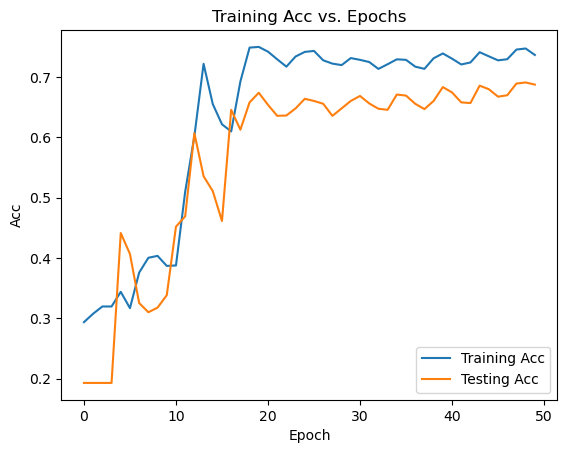

In [ ]:
LEARNING_RATE = 0.001
NUM_CLASSES = 4
BATCH_SIZE = 256
EPOCHS = 500

# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_pt = torch.tensor(train_data, dtype=torch.float)
train_labels_pt = F.one_hot(torch.tensor(train_labels, dtype=torch.long) - 1,  num_classes=NUM_CLASSES).float()

test_data_pt = torch.tensor(test_data, dtype=torch.float)
test_data_pt = test_data_pt.to(device)
test_labels_pt = F.one_hot(torch.tensor(test_labels, dtype=torch.long) - 1,  num_classes=NUM_CLASSES).float()

training_dataset = TensorDataset(train_data_pt.to(device), train_labels_pt.to(device))
dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = FirstCNN(num_classes=NUM_CLASSES).to(device)


criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in dataloader:

        # Zero the gradient buffers
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)


        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate loss & acc
        running_loss += loss.item()

        target_classes = torch.argmax(targets, dim=1)
        running_acc += compute_accuracy(outputs, target_classes.cpu())

    avg_acc = running_acc/len(dataloader)
    train_acc.append(avg_acc)

    # compute test accuracy as well
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():        
        test_outputs = model(test_data_pt)
        avg_test_acc = compute_accuracy(test_outputs, test_labels - 1)
        test_acc.append(avg_test_acc)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Accuracy: {avg_acc:.4f}, Test Accuracy: {avg_test_acc:.4f}")


plt.plot(train_acc, label='Training Acc')
plt.plot(test_acc, label='Testing Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Training Acc vs. Epochs')
plt.legend()
plt.show()


In [140]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_data_pt = torch.tensor(test_data, dtype=torch.float)

    test_data_pt = test_data_pt.to(device)
    
    test_outputs = model(test_data_pt)

    predicted_classes = torch.argmax(test_outputs, dim=1)

In [144]:
test_labels_pt = torch.tensor(test_labels - 1, dtype=torch.long)

# Compute micro and macro-averaged F1 scores
accuracy = accuracy_score(test_labels_pt, predicted_classes.cpu())
micro_f1 = f1_score(test_labels_pt, predicted_classes.cpu(), average='micro')
macro_f1 = f1_score(test_labels_pt, predicted_classes.cpu(), average='macro')
print(f'Accuracy: {accuracy}')
print(f'Micro-averaged F1 score: {micro_f1}')
print(f'Macro-averaged F1 score: {macro_f1}')

Accuracy: 0.8669805768098882
Micro-averaged F1 score: 0.8669805768098882
Macro-averaged F1 score: 0.8986277033588517
